In [11]:
import math
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import spacy
import matplotlib.pyplot as plt
from scipy.stats import linregress
nlp = spacy.load("en_core_web_lg")

OUTPUT_DIR="../src/data"
SCHOOL="minnesota"
SUBJECT="opinion"
START_YEAR=2022
FINAL_YEAR=2023

In [12]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N,
            np.trace(cov)/N,
            np.linalg.norm(cov, ord=1)/N,
            np.linalg.norm(cov, ord=2)/N,
            np.linalg.norm(cov, ord=np.inf)/N,
            )

def cosine_distance(a, b):
    dot = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)

    # Calculate and return the cosine distance
    return 1 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

diversity_words = ['diversity', 'equity','inclusion','inclusive','inclusivity','equality', 'equal opportunity','social justice','racial justice','multi-cultural','multicultural','intercultural','intersectional', 'intersectionality','anti-discrimination']
diversity_pattern = "\b" + "|".join(diversity_words) + "\b"

english_stopwords = stopwords.words('english')
def prepText(text_series):
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                 for text in text_series])
    return text_series, total_diversity_words

In [15]:
results = []
for year in range(START_YEAR, FINAL_YEAR + 1):
    df = pd.read_parquet(f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-{year}.parquet")

    df['body_prepped'], num_diversity_words = prepText(df.body)
    wv = [nlp(s) for s in df['body_prepped']]
    docmatrix = np.array([v.vector for v in wv])

    cov = getCovDispersion(docmatrix)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    result = {'year': year,
              'pairwise': pairwise,
              'size': cov[0],
              'trace': cov[1],
              'norm-1': cov[2],
              'norm-2': cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm': num_diversity_words / cov[0]
              }
    results.append(result)
    print(f"{year}, {cov[0]}, {pairwise}")

results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')



2022, 10, 0.06334850788116456
2023, 28, 0.036169392721993585


,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2022,0.063349,10,1.424693,1.485534,1.346003,1.485534,2,0.2
2023,0.036169,28,1.444417,1.448151,1.394316,1.448151,0,0.0


mentions-norm slope:-0.20000, int:0.20000, r:-1.00000, p:0.00000, se:0.00000, x:range(0, 2)
pairwise slope:-0.02718, int:0.06335, r:-1.00000, p:0.00000, se:0.00000, x:range(0, 2)


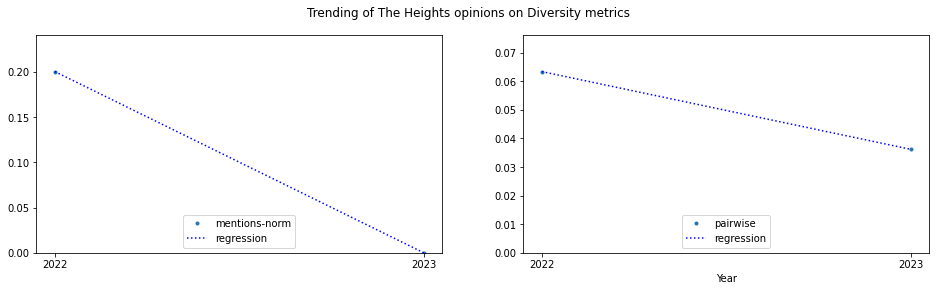

In [14]:
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16, 4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]

    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
        column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope * x, 'b:', label='regression')
    ax.set_ylim(0, max(y) * 1.2)

    # Add a legend
    ax.legend(loc='lower center')
    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

plt.xlabel("Year")
plt.suptitle("Trending of The Heights opinions on Diversity metrics")
plt.show()